In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading the dataset

In [103]:
df= pd.read_csv("training.1600000.processed.noemoticon.csv",encoding="latin-1",names=['target','id','date','flag','user','text'])
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### dropping the unwanted columns

In [104]:
df.drop(['id','date','flag','user'],axis=1,inplace=True)

In [105]:
pos_data= df[df.target== 4].iloc[:25000,:]
neg_data = df[df.target== 0].iloc[:25000,:]
df= pd.concat([pos_data, neg_data],axis=0)
df.head()

,target,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


###  No.of points per class

In [106]:
df.target.value_counts()

4    25000
0    25000
Name: target, dtype: int64

### Data Cleaning

In [14]:
import nltk
import re
import string
import warnings
warnings.filterwarnings("ignore")

In [15]:
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [107]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if len(token)>3:
            if token not in stop_words:
                if stem:
                    tokens.append(stemmer.stem(token))
                else:
                    tokens.append(token)
    return " ".join(tokens)

In [108]:
df['clean_text'] = df.text.apply(lambda x: preprocess(x))

In [109]:
label_map={0:'Negative',4:'Positive'}
def label(x):
    return label_map[int(x)]
df.target = df.target.apply(lambda x: label(x))
df.head()

,target,text,clean_text
800000,Positive,I LOVE @Health4UandPets u guys r the best!!,love health4uandpets guys best
800001,Positive,im meeting up with one of my besties tonight! ...,meeting besties tonight cant wait girl talk
800002,Positive,"@DaRealSunisaKim Thanks for the Twitter add, S...",thanks twitter sunisa meet show area sweetheart
800003,Positive,Being sick can be really cheap when it hurts t...,sick really cheap hurts much real food plus fr...
800004,Positive,@LovesBrooklyn2 he has that effect on everyone,effect everyone


In [110]:
data= df.copy()
df.drop(['text'],axis=1, inplace=True)


In [111]:
df.head()

,target,clean_text
800000,Positive,love health4uandpets guys best
800001,Positive,meeting besties tonight cant wait girl talk
800002,Positive,thanks twitter sunisa meet show area sweetheart
800003,Positive,sick really cheap hurts much real food plus fr...
800004,Positive,effect everyone


### Visualizing the text data

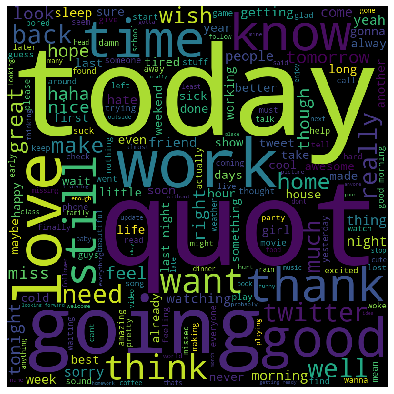

In [26]:
from wordcloud import WordCloud

#For Whole Text
words = ' '. join([tweet for tweet in df.clean_text]) 
wordcloud = WordCloud(width= 800, height=800, min_font_size= 10, random_state= 20 ).generate(words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

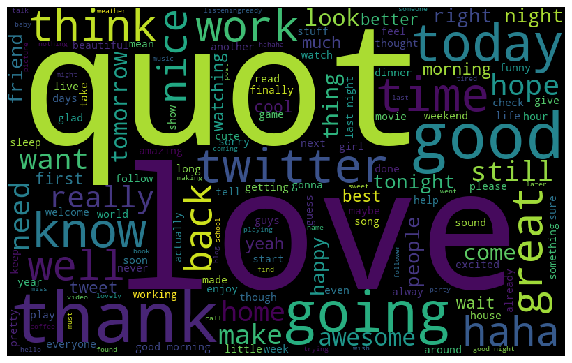

In [27]:
#For Positive Text
pos_words = ' '. join([tweet for tweet in data.clean_text[data.target=='Positive']]) 
wordcloud = WordCloud(width= 800, height=500, min_font_size= 10, random_state= 20 ).generate(pos_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

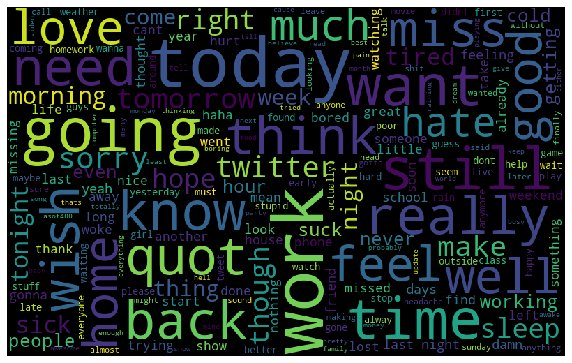

In [29]:
#For Negative Text
neg_words = ' '. join([tweet for tweet in data.clean_text[data.target=='Negative']]) 
wordcloud = WordCloud(width= 800, height=500, max_font_size= 100, random_state= 20 ).generate(neg_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Splitting the data

In [31]:
Y= df.target
X= df.drop(['target'], axis=1)

In [32]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.3)

### Encoding clean_text

#### BOW

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(min_df=10)
count_vec.fit(x_train.clean_text.values)
x_train_count_vec= count_vec.transform(x_train.clean_text.values)
x_test_count_vec= count_vec.transform(x_test.clean_text.values)

print('x_train_BOW shape', x_train_count_vec.shape,'y_train sahpe:', y_train.shape)
print('x_test_BOW shape', x_test_count_vec.shape,'y_test sahpe:', y_test.shape)

x_train_BOW shape (35000, 2500) y_train sahpe: (35000,)
x_test_BOW shape (15000, 2500) y_test sahpe: (15000,)


##### TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10)
tfidf.fit(x_train.clean_text.values)

x_train_tfidf=tfidf.transform(x_train.clean_text.values)
x_test_tfidf= tfidf.transform(x_test.clean_text.values)

print('x_train_tfidf shape', x_train_tfidf.shape,'y_train sahpe:', y_train.shape)
print('x_test_tfidf shape', x_test_tfidf.shape,'y_test sahpe:', y_test.shape)

x_train_tfidf shape (35000, 2500) y_train sahpe: (35000,)
x_test_tfidf shape (15000, 2500) y_test sahpe: (15000,)


### Building the model

In [35]:
#importing metrics
from sklearn import metrics
#importing RandomSearchCV for Hyper Parameter Tuning
from sklearn.model_selection import RandomizedSearchCV

##### Logistic Regression 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [61]:
#Logistic Regression with BOW


lr = LogisticRegression(random_state= 21). fit(x_train_count_vec, y_train)
lr_pred = lr.predict(x_test_count_vec)


In [62]:
from sklearn.metrics import accuracy_score
lr_bow_auc= accuracy_score(lr_pred, y_test)
print('lr_bow_acu :',lr_bow_auc)

lr_bow_acu : 0.7256


In [63]:
#Logistic Regression with TFIDF
lr_tfidf = LogisticRegression(random_state= 21). fit(x_train_tfidf, y_train)
lr_pred = lr_tfidf.predict(x_test_tfidf)

lr_tfidf_auc= accuracy_score(lr_pred, y_test)
print('lr_tfidf_acu :',lr_tfidf_auc)

lr_tfidf_acu : 0.7271333333333333


##### SVM

In [40]:
from sklearn import svm

In [67]:
#SVM with BOW
svc_bow = svm.SVC(random_state= 21).fit(x_train_count_vec, y_train)
svc_bow_pred = svc_bow.predict(x_test_count_vec)

#ACCURACY
svc_bow_auc = accuracy_score(svc_bow_pred, y_test)
print("svc_bow_auc:", svc_bow_auc)

svc_bow_auc: 0.6390666666666667


In [70]:
#SVM with TFIDF
svc_tfidf = svm.SVC(random_state= 21).fit(x_train_tfidf, y_train)
svc_tfidf_pred = svc_tfidf.predict(x_test_tfidf)

#ACCURACY
svc_tfidf_auc = accuracy_score(svc_tfidf_pred, y_test)
print("svc_tfidf_auc:", svc_tfidf_auc)

svc_tfidf_auc: 0.4992


##### Random Forest

In [44]:
 from sklearn.ensemble import RandomForestClassifier

In [94]:
#RF with BOW
rf_bow= RandomForestClassifier(random_state= 21, n_estimators= 1000)
rf_bow.fit(x_train_count_vec, y_train)
rf_bow_pred= rf_bow.predict(x_test_count_vec)

#Accuracy
rf_bow_auc= accuracy_score(rf_bow_pred, y_test)
print("rf_bow_auc: ",rf_bow_auc)

rf_bow_auc:  0.7034666666666667


In [96]:
#RF with TFIDF
rf_tfidf= RandomForestClassifier(random_state= 21, n_estimators=1000)
rf_tfidf.fit(x_train_tfidf, y_train)
rf_tfidf_pred= rf_tfidf.predict(x_test_tfidf)

#Accuracy
rf_tfidf_auc= accuracy_score(rf_tfidf_pred, y_test)
print("rf_tfidf_auc: ", rf_tfidf_auc)

rf_tfidf_auc:  0.7115333333333334


#####  XGBoost

In [48]:
from xgboost import XGBClassifier

In [50]:
#XGB with BOW
xgb_bow = XGBClassifier(random_state=21).fit(x_train_count_vec, y_train)
xgb_bow_pred= xgb_bow.predict(x_test_count_vec)

#accuracy
xgb_bow_auc=  accuracy_score(xgb_bow_pred, y_test)
print("xgb_bow_auc: ",xgb_bow_auc )

xgb_bow_auc:  0.7078


In [69]:
#XGB with TFIDF
xgb_tfidf = XGBClassifier(random_state=21).fit(x_train_tfidf, y_train)
xgb_tfidf_pred= xgb_tfidf.predict(x_test_tfidf)

#accuracy
xgb_tfidf_auc=  accuracy_score(xgb_tfidf_pred, y_test)
print("xgb_tfidf_auc: ",xgb_tfidf_auc )

xgb_tfidf_auc:  0.7045333333333333


### =================

In [52]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"learning_rate ":[0.05,0.1,0.2],
              "max_depth": range(3,100),
              "n_estimators": range(100,1000,50),
              "min_child_weight": range(1,6,2),
               "gamma":[i/10.0 for i in range(0,5)]}

clf = XGBClassifier(random_state=20,n_jobs=-1) 

xgb = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5,cv=10,scoring='roc_auc',verbose=50,return_train_score=True)

xgb.fit(x_train_count_vec,y_train)
print('mean test scores',xgb.cv_results_['mean_test_score'])
print('mean train scores',xgb.cv_results_['mean_train_score'])

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=150, min_child_weight=5, max_depth=87, learning_rate =0.05, gamma=0.0 
[CV]  n_estimators=150, min_child_weight=5, max_depth=87, learning_rate =0.05, gamma=0.0, score=(train=0.904, test=0.806), total=  34.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.6s remaining:    0.0s
[CV] n_estimators=150, min_child_weight=5, max_depth=87, learning_rate =0.05, gamma=0.0 
[CV]  n_estimators=150, min_child_weight=5, max_depth=87, learning_rate =0.05, gamma=0.0, score=(train=0.905, test=0.787), total=  37.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s
[CV] n_estimators=150, min_child_weight=5, max_depth=87, learning_rate =0.05, gamma=0.0 
[CV]  n_estimators=150, min_child_weight=5, max_depth=87, learning_rate =0.05, gamma=0.0, score=(train=0.905, test=0.788), total=  47.8s
[Parallel(n_jobs=1)]

[CV]  n_estimators=650, min_child_weight=3, max_depth=9, learning_rate =0.1, gamma=0.1, score=(train=0.863, test=0.790), total=  19.6s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 23.2min remaining:    0.0s
[CV] n_estimators=650, min_child_weight=3, max_depth=9, learning_rate =0.1, gamma=0.1 
[CV]  n_estimators=650, min_child_weight=3, max_depth=9, learning_rate =0.1, gamma=0.1, score=(train=0.864, test=0.790), total=  20.2s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 23.5min remaining:    0.0s
[CV] n_estimators=650, min_child_weight=3, max_depth=9, learning_rate =0.1, gamma=0.1 
[CV]  n_estimators=650, min_child_weight=3, max_depth=9, learning_rate =0.1, gamma=0.1, score=(train=0.863, test=0.793), total=  19.1s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 23.8min remaining:    0.0s
[CV] n_estimators=300, min_child_weight=5, max_depth=21, learning_rate =0.1, gamma=0.0 
[CV]  n_estimators=300, min_child_weight=5, max_depth=21, learning_rate =0.1, gamma=0.0, scor

In [55]:
xgb_bow= xgb.best_estimator_
xgb_bow.fit(x_train_count_vec,y_train)
xgb_bow_pred= xgb_bow.predict(x_test_count_vec)
#accuracy
xgb_bow_auc = accuracy_score(xgb_bow_pred,y_test) 
print("xgb_bow_auc: ", xgb_bow_auc)

xgb_bow_auc:  0.7256666666666667


In [58]:
from sklearn.linear_model import SGDClassifier
clf= SGDClassifier(loss='log')
clf.fit(x_train_tfidf, y_train)
clf_pred= clf.predict(x_test_tfidf)

print(accuracy_score(clf_pred, y_test))

0.727


### Model Comparision

In [71]:
Model_auc_dic= {'Logistic Regression[BOW]': lr_bow_auc,'Logistic Regression[TFIDF]': lr_tfidf_auc,
                 'SVC[BOW]': svc_bow_auc,'SVC[TFIDF]': svc_tfidf_auc,
                 'RandomForest[BOW]': rf_bow_auc,'RandomForest[TFIDF]': rf_tfidf_auc,
                    'XGBoost[BOW]':xgb_bow_auc,'XGBoost[TFIDF]': xgb_tfidf_auc}


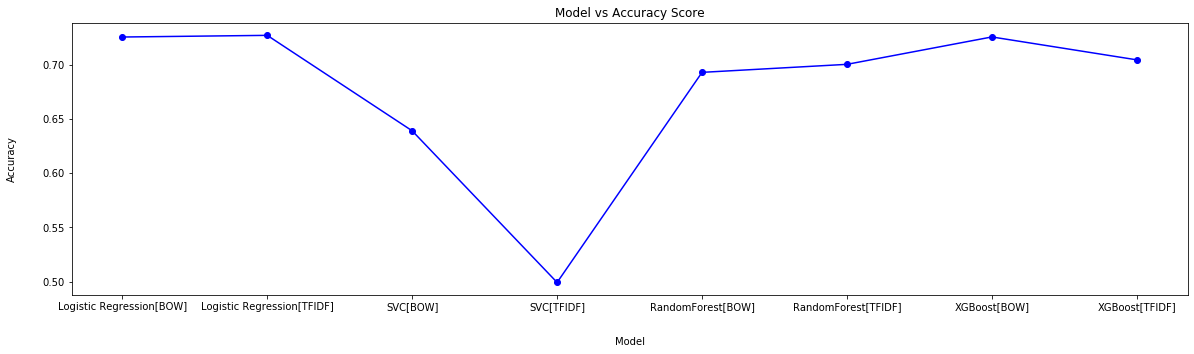

In [93]:
plt.figure(figsize=(20,5))
plt.plot(list(Model_auc_dic.keys()),list(Model_auc_dic.values()),'b-o')
plt.title("Model vs Accuracy Score")
plt.xlabel("Model",labelpad= 25)
plt.ylabel("Accuracy",labelpad= 25)
plt.show()

#### Testing

In [101]:
test_tweet = ['I hate you']
test_tweet=tfidf.transform(test_tweet)
lr_tfidf.predict(test_tweet)

array(['Negative'], dtype=object)

In [102]:
test_tweet = ['you are good']
test_tweet=tfidf.transform(test_tweet)
lr_tfidf.predict(test_tweet)

array(['Positive'], dtype=object)